# Neural Networks with TensorFlow and Keras 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.22.0


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.5.0


In [5]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.1.4


## First Step: Load Data and disassemble for our purposes
### We need a few more data point samples for this approach

In [6]:
# df = pd.read_csv('./insurance-customers-300.csv', sep=';')
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [7]:
y=df['group']

In [8]:
df.drop('group', axis='columns', inplace=True)

In [9]:
X = df.as_matrix()

In [10]:
df.describe()

,max speed,age,thousand km per year
count,1500.000000,1500.000000,1500.000000
mean,171.386000,44.969333,30.511333
std,19.269126,16.935040,15.112317
min,118.000000,18.000000,5.000000
25%,158.000000,32.000000,18.000000
50%,170.000000,42.000000,29.000000
75%,187.000000,55.000000,42.000000
max,216.000000,90.000000,84.000000


## Second Step: Deep Learning as Alchemy

In [11]:
# ignore this, it is just technical code
# should come from a lib, consider it to appear magically 
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#AAAA00'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, colors, title="", mesh=True, fixed=None, fname=None):
    xx,yy = meshGrid(x_data, y_data)
    plt.figure(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    if fname:
        plt.scatter(x_data, y_data, c=colors, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        plt.scatter(x_data, y_data, c=colors, cmap=cmap_bold, s=80, marker='o', edgecolors='k')
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    plt.title(title, fontsize=font_size)
    if fname:
        plt.savefig(fname)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [15]:
X_train_kmh_age = X_train[:, :2]
X_test_kmh_age = X_test[:, :2]
X_train_2_dim = X_train_kmh_age
X_test_2_dim = X_test_kmh_age

In [16]:
# tiny little pieces of feature engeneering
from keras.utils.np_utils import to_categorical

num_categories = 3

y_train_categorical = to_categorical(y_train, num_categories)
y_test_categorical = to_categorical(y_test, num_categories)

In [20]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout

inputs = Input(name='input', shape=(2, ))
x = Dense(100, name='hidden1', activation='relu')(inputs)
x = Dense(100, name='hidden2', activation='relu')(x)
x = Dense(100, name='hidden3', activation='relu')(x)
predictions = Dense(3, name='softmax', activation='softmax')(x)
model = Model(input=inputs, output=predictions)

# loss function: http://cs231n.github.io/linear-classify/#softmax
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 100)               300       
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
softmax (Dense)              (None, 3)                 303       
Total params: 20,803
Trainable params: 20,803
Non-trainable params: 0
_________________________________________________________________


### What is the intuition here: none, just fiddle around like everyone
This might be frustrating or even seem wrong, but trust me: this is more or less what everyone does

In [21]:
%time model.fit(X_train_2_dim, y_train_categorical, epochs=1000, verbose=0, batch_size=100)
# %time model.fit(X_train_2_dim, y_train_categorical, epochs=1000, validation_split=0.2, verbose=0, batch_size=100)

Wall time: 1min 40s


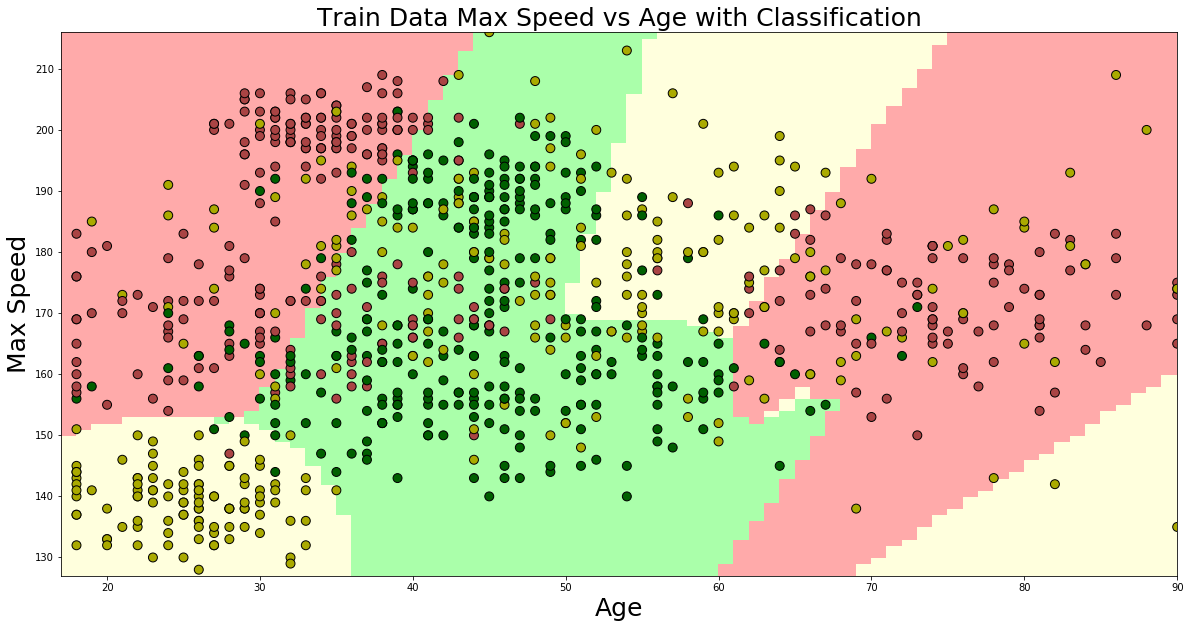

In [22]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data Max Speed vs Age with Classification")

In [23]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train_categorical, batch_size=100)
train_accuracy

900/900 [==============================] - 0s 71us/step


0.7044444415304396

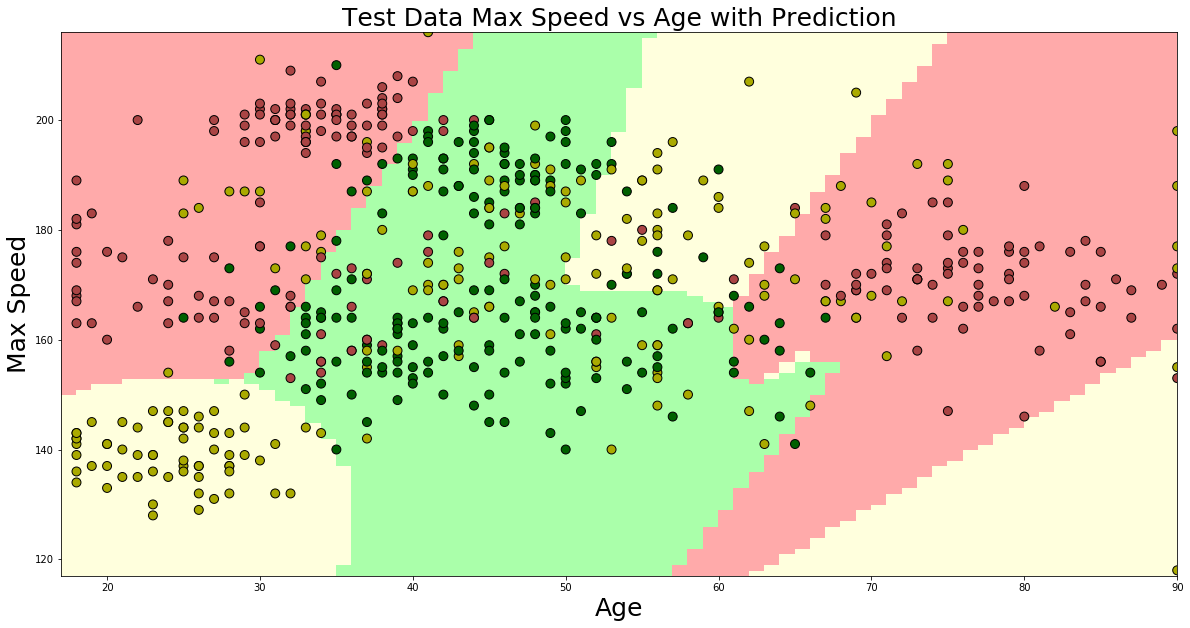

In [24]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data Max Speed vs Age with Prediction")

In [25]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test_categorical, batch_size=100)
test_accuracy

600/600 [==============================] - 0s 30us/step


0.7050000031789144

### No overfitting, probably as good as it gets
## Does this look like your manual solution?
### The machine isn't better than you?

Your brain is a great pattern matcher, but only in 2-d. 

## Third Step: Use all dimensions
* And possibly some drop out to avoid overfitting

In [26]:
drop_out = 0.15

inputs = Input(name='input', shape=(3, ))
x = Dense(100, name='hidden1', activation='relu')(inputs)
x = Dropout(drop_out)(x)
x = Dense(100, name='hidden2', activation='relu')(x)
x = Dropout(drop_out)(x)
x = Dense(100, name='hidden3', activation='relu')(x)
x = Dropout(drop_out)(x)
# x = Dense(100, name='hidden4', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
# x = Dense(100, name='hidden5', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
predictions = Dense(3, name='softmax', activation='softmax')(x)
model = Model(input=inputs, output=predictions)

# loss function: http://cs231n.github.io/linear-classify/#softmax
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
%time model.fit(X_train, y_train_categorical, epochs=1000, verbose=0, batch_size=100)
# %time model.fit(X_train, y_train_categorical, epochs=1000, validation_split=0.2, verbose=0, batch_size=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 3)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [27]:
train_loss, train_accuracy = model.evaluate(X_train, y_train_categorical, batch_size=100)
train_accuracy

900/900 [==============================] - 0s 135us/step


0.7655555473433601

In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, batch_size=100)
test_accuracy

600/600 [==============================] - 0s 201us/step


0.7399999996026357

### This is so much more, look at all the different shapes for different kilometers per year

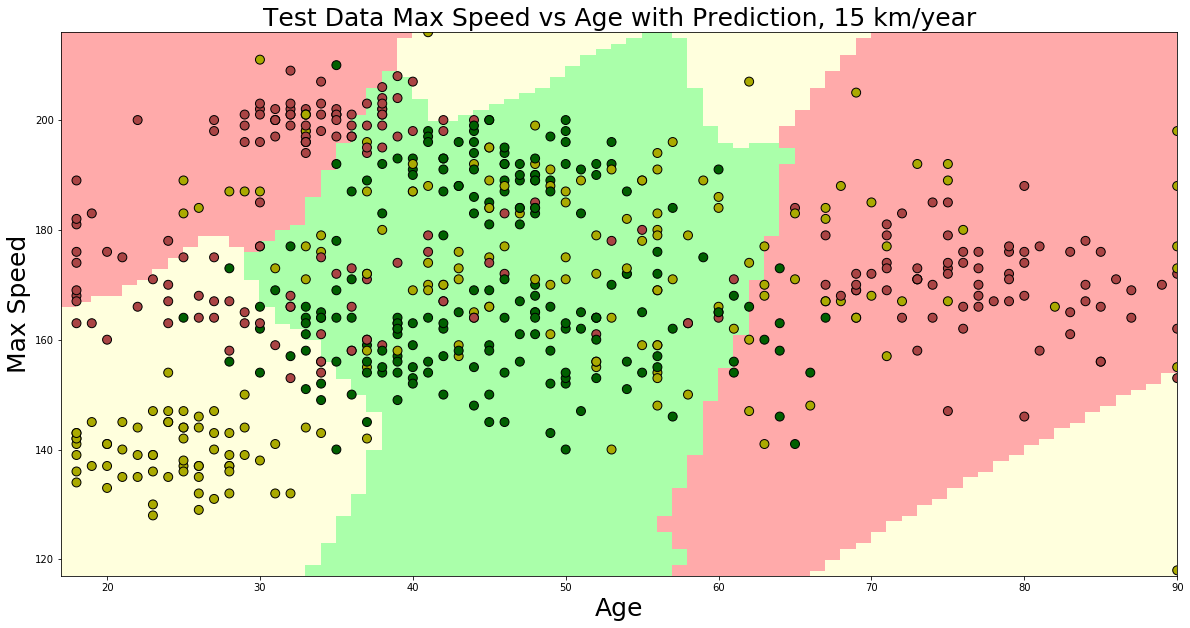

In [29]:
kms_per_year = 15
plotPrediction(model, X_test[:, 1], X_test[:, 0],
               'Age', 'Max Speed', y_test,
                fixed = kms_per_year,
                title="Test Data Max Speed vs Age with Prediction, 15 km/year")

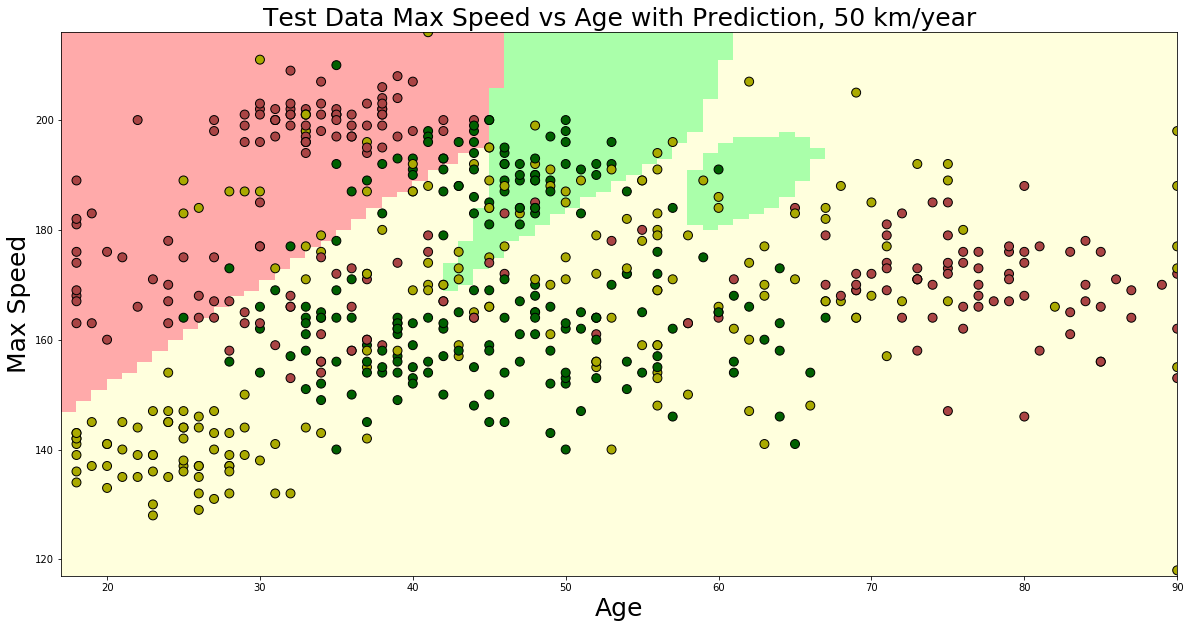

In [30]:
kms_per_year = 50
plotPrediction(model, X_test[:, 1], X_test[:, 0],
               'Age', 'Max Speed', y_test,
                fixed = kms_per_year,
                title="Test Data Max Speed vs Age with Prediction, 50 km/year")

Text(33,0.5,'Ground Truth')

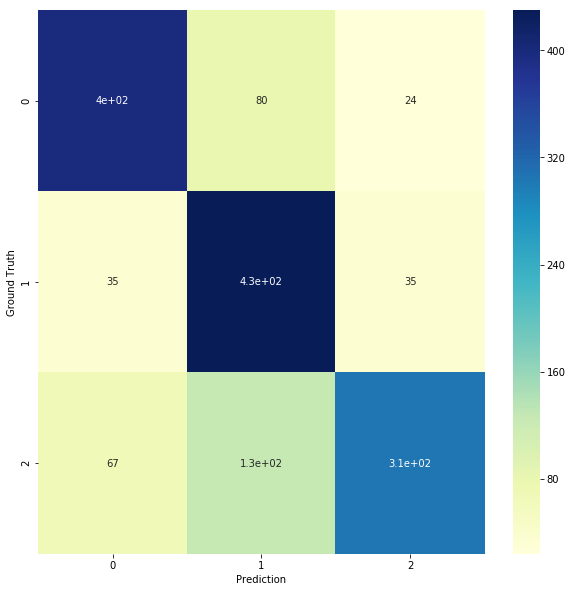

In [31]:
prediction = model.predict(X)
y_pred = np.argmax(prediction, axis=1)

y_true = y

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

import seaborn as sns
sns.heatmap(cm, annot=True, cmap="YlGnBu")
figure = plt.gcf()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(111)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')

## Fouth Step: Publish Model to Google Cloud ML and try it out
* Unfortunately, for technical limitations, we need to get rid of the dropouts for that

In [37]:
inputs = Input(name='input', shape=(3, ))
x = Dense(80, name='hidden1', activation='relu')(inputs)
x = Dense(80, name='hidden2', activation='relu')(x)
x = Dense(80, name='hidden3', activation='relu')(x)
predictions = Dense(3, name='softmax', activation='softmax')(x)
model = Model(input=inputs, output=predictions)

# loss function: http://cs231n.github.io/linear-classify/#softmax
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

%time model.fit(X_train, y_train_categorical, epochs=1000, verbose=0, batch_size=100)
# %time model.fit(X_train, y_train_categorical, epochs=1000, validation_split=0.2, verbose=0, batch_size=100)

train_loss, train_accuracy = model.evaluate(X_train, y_train_categorical, batch_size=100)
print(train_accuracy)

test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, batch_size=100)
print(test_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 3)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 80)                320       
_________________________________________________________________
hidden2 (Dense)              (None, 80)                6480      
_________________________________________________________________
hidden3 (Dense)              (None, 80)                6480      
_________________________________________________________________
softmax (Dense)              (None, 3)                 243       
Total params: 13,523
Trainable params: 13,523
Non-trainable params: 0
_________________________________________________________________
CPU times: user 33.8 s, sys: 3.22 s, total: 37.1 s
Wall time: 19.2 s
900/900 [==============================] - 0s 77us/step
0.75999999046

In [38]:
!rm -rf tf

In [39]:
import os
from keras import backend as K

# K.clear_session()

K.set_learning_phase(0)

export_path_base = 'tf'
export_path = os.path.join(
  tf.compat.as_bytes(export_path_base),
  tf.compat.as_bytes("1"))

sess = K.get_session()

classification_inputs = tf.saved_model.utils.build_tensor_info(model.input)
classification_outputs_scores = tf.saved_model.utils.build_tensor_info(model.output)

from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def

signature = predict_signature_def(inputs={'inputs': model.input},
                                  outputs={'scores': model.output})

builder = tf.saved_model.builder.SavedModelBuilder(export_path)

builder.add_meta_graph_and_variables(
      sess, 
     tags=[tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature
      })

builder.save()

b'tf/1/saved_model.pb'

In [40]:
!ls -lhR tf

tf:
total 0
drwxrwxrwx 0 root root 512 Feb  3 22:28 1

tf/1:
total 560K
-rwxrwxrwx 1 root root 559K Feb  3 22:28 saved_model.pb
drwxrwxrwx 0 root root  512 Feb  3 22:28 variables

tf/1/variables:
total 896K
-rwxrwxrwx 1 root root 892K Feb  3 22:28 variables.data-00000-of-00001
-rwxrwxrwx 1 root root 3.4K Feb  3 22:28 variables.index


In [41]:
!saved_model_cli show --dir tf/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
inputs['inputs'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 3)
    name: input_3:0
The given SavedModel SignatureDef contains the following output(s):
outputs['scores'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 3)
    name: softmax_3/Softmax:0
Method name is: tensorflow/serving/predict


In [42]:
# 0: red
# 1: green
# 2: yellow

!saved_model_cli run --dir tf/1 --tag_set serve --signature_def serving_default --input_exprs 'inputs=[[160.0,47.0,15.0]]'

2018-02-03 22:32:53.825506: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-02-03 22:32:53.825573: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-02-03 22:32:53.825612: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2018-02-03 22:32:53.825643: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2018-02-03 22:32:53.825660: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [43]:
!cat sample_insurance.json

In [ ]:
# https://cloud.google.com/ml-engine/docs/deploying-models

# Copy model to bucket
# gsutil cp -R tf/1 gs://booster_bucket

# create model and version at https://console.cloud.google.com/mlengine

# try ouy deployed
# gcloud ml-engine predict --model=booster --version=v1 --json-instances=./sample_insurance.json
# SCORES
# [0.003163766348734498, 0.9321494698524475, 0.06468681246042252]
# [2.467862714183866e-08, 1.2279541668431052e-14, 1.0]